<!-- ## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session -->

## Neural Network from scratch
* Single layer neural network.
* Used softmax and relu as activation functions
* aquired accuracies provided at end.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.model_selection as model_selection 
import sklearn.preprocessing as preprocessing 
import sklearn.metrics as metrics 
from tqdm import tqdm

In [3]:
X_train = pd.read_csv("/kaggle/input/assignment2task1dset/train_X.csv",index_col=0).to_numpy()
y_train = pd.read_csv("/kaggle/input/assignment2task1dset/train_y.csv",index_col=0).to_numpy().reshape(-1,)
X_test = pd.read_csv("/kaggle/input/assignment2task1dset/test_X.csv",index_col=0).to_numpy()
submissions_df = pd.read_csv("/kaggle/input/assignment2task1dset/sample_submission.csv",index_col=0)

In [4]:
print("X_train shape:",X_train.shape)
print("Y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("submissions_df shape:",submissions_df.shape)

X_train shape: (60000, 784)
Y_train shape: (60000,)
X_test shape: (10000, 784)
submissions_df shape: (10000, 1)


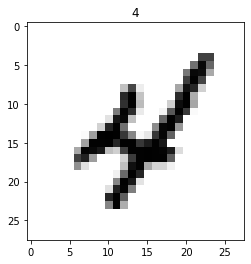

In [5]:
index = 9
plt.title((y_train[index]))
plt.imshow(X_train[index].reshape(28,28), cmap=cm.binary)

In [6]:
print("train data")
y_value = np.zeros((1,10))
for i in range (10):
    print("occurance of ",i,"=",np.count_nonzero(y_train==i))
    y_value[0,i-1] =  np.count_nonzero(y_train==i)

train data
occurance of  0 = 5923
occurance of  1 = 6742
occurance of  2 = 5958
occurance of  3 = 6131
occurance of  4 = 5842
occurance of  5 = 5421
occurance of  6 = 5918
occurance of  7 = 6265
occurance of  8 = 5851
occurance of  9 = 5949


<BarContainer object of 10 artists>

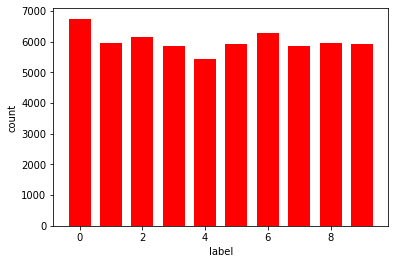

In [7]:
y_value = y_value.ravel()
x_value = [0,1,2,3,4,5,6,7,8,9]
plt.xlabel('label')
plt.ylabel('count')
plt.bar(x_value,y_value,0.7,color='red')

In [8]:
# one hot encoding of label y

Y_train = np.zeros((10,60000))
for column in range(60000):
    v = y_train[column]
    for row in range(10):
        if(v==row):
            Y_train[v,column] = 1
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)

X_train shape: (60000, 784)
Y_train shape: (10, 60000)


In [9]:
#  transpose of x

X_train=X_train.T
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)


X_train shape: (784, 60000)
Y_train shape: (10, 60000)


# **Activation Functions**

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0,x)

def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp_X = np.exp(x)
    Z = exp_X / np.sum(exp_X,axis = 0)
    return Z

**Derivative of activation functions**

In [11]:
def deri_relu(x):
    return np.array(x > 0 , dtype = np.float32)

def deri_tanh(x):
    t = tanh(x)
    return (1-(np.power(t,2)))

def deri_sigmoid(x):
    s = sigmoid(x)
    return s * (1-s)



# **Initialization**

In [12]:
def initlz_params(n_i, n_h, n_o):
    w1 = np.random.randn(n_h, n_i)*0.001
    b1 = np.zeros((n_h, 1))
    
    w2 = np.random.randn(n_o, n_h)*0.001
    b2 = np.zeros((n_o, 1))
    
    params = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return params

# **Forward Propogation**

In [13]:
def fwd_prop(x, params):
    
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']
    
    z1 = np.dot(w1, x) + b1
    a1 = relu(z1)
    
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)
    
    fwd_var = {
        "z1" : z1,
        "a1" : a1,
        "z2" : z2,
        "a2" : a2
    }
    
    return fwd_var

# **Cost Function**

In [14]:
def cost_function(a2, y):
    m = y.shape[1]
    
    cost = -(1/m)*np.sum(y*np.log(a2))
    
    #cost = -(1/m)*np.sum(np.sum(y*np.log(a2, 0), 1))
    
    return cost

# **Backpropogation**

In [15]:
def backward_prop(x, y, params, fwd_var):
    
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']
    
    a1 = fwd_var['a1']
    a2 = fwd_var['a2']
    
    m = x.shape[1]
    
    dz2 = (a2 - y)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)
    
    dz1 = (1/m)*np.dot(w2.T, dz2)*deri_relu(a1)
    dw1 = (1/m)*np.dot(dz1, x.T)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
    grads = {
        "dw1" : dw1,
        "db1" : db1,
        "dw2" : dw2,
        "db2" : db2
    }
    
    return grads

# **Parameters update**

In [16]:
def update_params(params, grads, learning_rate):
    
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']
    
    dw1 = grads['dw1']
    db1 = grads['db1']
    dw2 = grads['dw2']
    db2 = grads['db2']
    
    w1 = w1 - learning_rate*dw1
    b1 = b1 - learning_rate*db1
    w2 = w2 - learning_rate*dw2
    b2 = b2 - learning_rate*db2
    
    params = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return params

# **Neural Network**

In [17]:
def model(x, y, n_h, learning_rate, iterations):
    
    n_i = x.shape[0]
    n_o = y.shape[0]
    
    cost_list = []
    
    params = initlz_params(n_i, n_h, n_o)
    
    for i in range(iterations):
        
        fwd_var = fwd_prop(x, params)
        
        cost = cost_function(fwd_var['a2'], y)
        
        grads = backward_prop(x, y, params, fwd_var)
        
        params = update_params(params, grads, learning_rate)
        
        cost_list.append(cost)
        
        if(i%(iterations/10) == 0):
            print("Cost after", i, "iterations is :", cost)
        
    return params, cost_list

In [24]:
iterations = 100
n_h = 1000
learning_rate = 0.8
Parameters, Cost_list = model(X_train, Y_train, n_h = n_h, learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 2.303742674278164
Cost after 10 iterations is : 0.6505595179359847
Cost after 20 iterations is : 0.4232839754942458
Cost after 30 iterations is : 0.33864245450359576
Cost after 40 iterations is : 0.29151429956204267
Cost after 50 iterations is : 0.2605523737258719
Cost after 60 iterations is : 0.2380750631608077
Cost after 70 iterations is : 0.22068288559168142
Cost after 80 iterations is : 0.20666028064395428
Cost after 90 iterations is : 0.19496315388511387


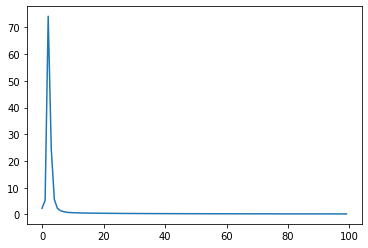

In [25]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [26]:
def accuracy(inp, labels, params):
    fwd_var = fwd_prop(inp, params)
    a_out = fwd_var['a2']   # containes propabilities with shape(10, 1)
    
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    labels = np.argmax(labels, 0)
    
    acc = np.mean(a_out == labels)*100
    
    return acc

In [27]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")

Accuracy of Train Dataset 94.66499999999999 %


In [28]:
X_test=X_test.T
fwd_var = fwd_prop(X_test, Parameters)
a_out = fwd_var['a2']   # containes propabilities with shape(10, 1)
a_out = np.argmax(a_out, 0)

In [36]:
submissions_df=pd.DataFrame({'label':a_out})

In [37]:
submissions_df.head()

,label
0,7
1,2
2,1
3,0
4,4


In [39]:
submissions_df.to_csv("{}__{}.csv".format('MT2022008','Akanksha'))

tanh activation
* alpha=0.02  85
* alpha=0.03  87
* alpha=0.06  90
* alpha=0.09  90.95
* alpha=0.1  91
* alpha=0.5  93.38
* alpha=0.03 500itr 91.82
* alpha=0.5 300 itr 95.36
* alpha=0.5 200 itr 94.54
* alpha=0.5 400 itr 95.74


relu
* alpha=0.02 91
* alpha=0.05 91.81
* alpha=0.9 74
* alpha=0.03 90.905
* alpha=0.5 94.48
* alpha=0.55 94.61
* alpha=0.575 94.068
* alpha=0.6 94.028
* alpha=0.65 93.86
* alpha=0.5 200 itr 95.86 
* alpha=0.5 300 itr 96.59
* alpha=0.5 400 itr 97.3633
* alpha=0.5 400 itr n_h256 95.78
* alpha=0.5 500 itr n_h500 96.50
* alpha=0.6 500 itr n_h500 96.59
* alpha=0.8 200 itr n_h500 95.64